# Image Classification (Cats vs Dogs)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import statistics
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()

In [2]:
use_gpu

False

## Data

In [3]:
DATA_DIR ='/Users/mahrokh/Desktop/dogcat/'

sz = 224
batch_size = 16

In [4]:
os.listdir(DATA_DIR)

['valid', '.DS_Store', 'test', 'sampleSubmission.csv', 'train', 'dev']

In [5]:
trn_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

In [6]:
os.listdir(trn_dir)

['cat', '.DS_Store', 'dog']

In [7]:
os.listdir(valid_dir)

['cat', '.DS_Store', 'dog']

In [8]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['/Users/mahrokh/Desktop/dogcat/train/cat/cat.5077.jpg',
 '/Users/mahrokh/Desktop/dogcat/train/cat/cat.2718.jpg',
 '/Users/mahrokh/Desktop/dogcat/train/cat/cat.10151.jpg',
 '/Users/mahrokh/Desktop/dogcat/train/cat/cat.3406.jpg',
 '/Users/mahrokh/Desktop/dogcat/train/cat/cat.4369.jpg']

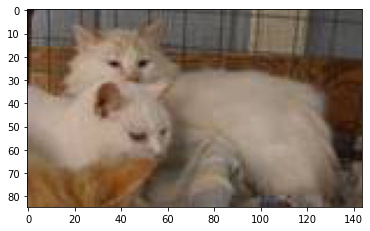

In [9]:
img = plt.imread(trn_fnames[735])
plt.imshow(img);

## Datasets and Dataloaders in PyTorch

In [10]:
train_ds = datasets.ImageFolder(trn_dir)

In [11]:
train_ds.classes

['cat', 'dog']

In [12]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [13]:
train_ds.root

'/Users/mahrokh/Desktop/dogcat/train'

In [14]:
train_ds.imgs[:3]

[('/Users/mahrokh/Desktop/dogcat/train/cat/cat.10000.jpg', 0),
 ('/Users/mahrokh/Desktop/dogcat/train/cat/cat.10001.jpg', 0),
 ('/Users/mahrokh/Desktop/dogcat/train/cat/cat.10002.jpg', 0)]

In [15]:
type(train_ds.transform)

NoneType

# Transformations

In [16]:
tfms = transforms.Compose([transforms.Resize((sz, sz)), 
                          transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
                          ])
train_ds = datasets.ImageFolder(trn_dir, tfms)
valid_ds = datasets.ImageFolder(valid_dir, tfms)

In [17]:
len(train_ds), len(valid_ds)

(21112, 3258)

# Dataloader

In [18]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                                      num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, 
                                      num_workers=8)

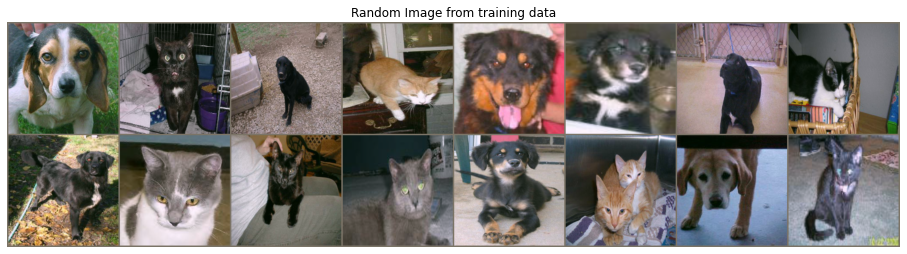

In [19]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16,12))
imshow(out, title='Random Image from training data')

# Model: CNN

In [20]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
                nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56* 56* 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [21]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

In [22]:
use_gpu

False

## Loss Function and Optimizer

In [23]:
criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

## Train

In [ ]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data[0]]
        
        # backward pass
        loss.backward()
       
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
          % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size,loss.data[0]))